### Iterated Entanglement Swapping using tket

In this tutorial, we will focus on:
- designing circuits with mid-circuit measurement and conditional gates;
- utilising noise models in supported simulators.

This example assumes the reader is familiar with the Qubit Teleportation and Entanglement Swapping protocols, and basic models of noise in quantum devices.

To run this example, you will need `pytket`, `pytket-qiskit`, and `plotly`.

Current quantum hardware fits into the NISQ (Noisy, Intermediate-Scale Quantum) regime. This noise cannot realistically be combatted using conventional error correcting codes, because of the lack of available qubits, noise levels exceeding the code thresholds, and very few devices available that can perform measurements and corrections mid-circuit. Analysis of how quantum algorithms perform under noisy conditions is a very active research area, as is finding ways to cope with it. Here, we will look at how well we can perform the Entanglement Swapping protocol with different noise levels.

The Entanglement Swapping protocol requires two parties to share Bell pairs with a third party, who applies the Qubit Teleportation protocol to generate a Bell pair between the two parties. The Qubit Teleportation step requires us to be able to measure some qubits and make subsequent corrections to the remaining qubits. There are only a handful of simulators and devices that currently support this, with others restricted to only measuring the qubits at the end of the circuit.

The most popular circuit model with conditional gates at the moment is that provided by the OpenQASM language. This permits a very restricted model of classical logic, where we can apply a gate conditionally on the exact value of a classical register. There is no facility in the current spec for Boolean logic or classical operations to apply any function to the value prior to the equality check. For example, Qubit Teleportation can be performed by the following QASM:

```OPENQASM 2.0;
include "qelib1.inc";
qreg a[2];
qreg b[1];
creg c[2];
// Bell state between Alice and Bob
h a[1];
cx a[1],b[0];
// Bell measurement of Alice's qubits
cx a[0],a[1];
h a[0];
measure a[0] -> c[0];
measure a[1] -> c[1];
// Correction of Bob's qubit
if(c==1) z b[0];
if(c==3) z b[0];
if(c==2) x b[0];
if(c==3) x b[0];
```

This corresponds to the following `pytket` code:

In [1]:
from pytket import Circuit

qtel = Circuit()
alice = qtel.add_q_register("a", 2)
bob = qtel.add_q_register("b", 1)
data = qtel.add_c_register("d", 2)

# Bell state between Alice and Bob
qtel.H(alice[1])
qtel.CX(alice[1], bob[0])

# Bell measurement of Alice's qubits
qtel.CX(alice[0], alice[1])
qtel.H(alice[0])
qtel.Measure(alice[0], data[0])
qtel.Measure(alice[1], data[1])

# Correction of Bob's qubit
qtel.X(bob[0], condition_bits=[data[0], data[1]], condition_value=2)
qtel.X(bob[0], condition_bits=[data[0], data[1]], condition_value=3)
qtel.Z(bob[0], condition_bits=[data[0], data[1]], condition_value=1)
qtel.Z(bob[0], condition_bits=[data[0], data[1]], condition_value=3)

[H a[1]; CX a[1], b[0]; CX a[0], a[1]; H a[0]; Measure a[1] --> d[1]; Measure a[0] --> d[0]; IF ([d[0], d[1]] == 2) THEN X b[0]; IF ([d[0], d[1]] == 3) THEN X b[0]; IF ([d[0], d[1]] == 1) THEN Z b[0]; IF ([d[0], d[1]] == 3) THEN Z b[0]; ]

So to demonstrate the Entanglement Swapping protocol, we just need to run this on one side of a Bell pair.

In [2]:
es = Circuit()
ava = es.add_q_register("a", 1)
bella = es.add_q_register("b", 2)
charlie = es.add_q_register("c", 1)
data = es.add_c_register("d", 2)

# Bell state between Ava and Bella
es.H(ava[0])
es.CX(ava[0], bella[0])

# Teleport bella[0] to charlie[0]
tel_to_c = qtel.copy()
tel_to_c.rename_units({alice[0] : bella[0], alice[1] : bella[1], bob[0] : charlie[0]})
es.append(tel_to_c)

print(es.get_commands())

[H a[0];, H b[1];, CX a[0], b[0];, CX b[1], c[0];, CX b[0], b[1];, H b[0];, Measure b[1] --> d[1];, Measure b[0] --> d[0];, IF ([d[0], d[1]] == 2) THEN X c[0];, IF ([d[0], d[1]] == 3) THEN X c[0];, IF ([d[0], d[1]] == 1) THEN Z c[0];, IF ([d[0], d[1]] == 3) THEN Z c[0];]


Let's start by running a noiseless simulation of this to verify that what we get looks like a Bell pair.

In [3]:
from pytket.backends.ibm import AerBackend

# Connect to a simulator
backend = AerBackend()

# Make a ZZ measurement of the Bell pair
bell_test = es.copy()
bell_test.Measure(ava[0], data[0])
bell_test.Measure(charlie[0], data[1])

# Run the experiment

backend.compile_circuit(bell_test)
from pytket.extensions.qiskit import tk_to_qiskit
print(tk_to_qiskit(bell_test))
handle = backend.process_circuit(bell_test, n_shots=2000)
counts = backend.get_result(handle).get_counts()

print(counts)

     ┌─────────────┐                                                   ┌─┐   
a_0: ┤ U3(π/2,0,π) ├──■────────────────────────────────────────────────┤M├───
     └─────────────┘┌─┴─┐       ┌─────────────┐┌─┐                     └╥┘   
b_0: ───────────────┤ X ├───■───┤ U3(π/2,0,π) ├┤M├──────────────────────╫────
     ┌─────────────┐└───┘ ┌─┴─┐ └─────┬─┬─────┘└╥┘                      ║    
b_1: ┤ U3(π/2,0,π) ├──■───┤ X ├───────┤M├───────╫───────────────────────╫────
     └─────────────┘┌─┴─┐ ├───┤       └╥┘       ║  ┌───┐  ┌───┐  ┌───┐  ║ ┌─┐
c_0: ───────────────┤ X ├─┤ X ├────────╫────────╫──┤ X ├──┤ Z ├──┤ Z ├──╫─┤M├
                    └───┘ └─┬─┘        ║        ║  └─┬─┘  └─┬─┘  └─┬─┘  ║ └╥┘
                         ┌──┴──┐       ║        ║ ┌──┴──┐┌──┴──┐┌──┴──┐ ║  ║ 
d: 2/════════════════════╡ = 2 ╞═══════╩════════╩═╡ = 3 ╞╡ = 1 ╞╡ = 3 ╞═╩══╩═
                         └─────┘       1        0 └─────┘└─────┘└─────┘ 0  1 
Counter({(0, 0): 1004, (1, 1): 996})


This is good, we have got roughly 50/50 measurement results of 00 and 11 under the ZZ operator. But there are many other states beyond the Bell state that also generate this distribution, so to gain more confidence in our claim about the state we should make more measurements that also characterise it, i.e. perform state tomography.

Here, we will demonstrate a naive approach to tomography that makes 3^n measurement circuits for an n-qubit state. More elaborate methods also exist.

In [4]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import append_pauli_measurement, probs_from_counts
from itertools import product
from scipy.linalg import lstsq, eigh
import numpy as np

def gen_tomography_circuits(state, qubits, bits):
    # Yields {X, Y, Z}^n measurements in lexicographical order
    # Only measures qubits, storing the result in bits
    # (since we don't care about the ancilla qubits)
    assert len(qubits) == len(bits)
    for paulis in product([Pauli.X, Pauli.Y, Pauli.Z], repeat=len(qubits)):
        circ = state.copy()
        for qb, b, p in zip(qubits, bits, paulis):
            if p == Pauli.X:
                circ.H(qb)
            elif p == Pauli.Y:
                circ.V(qb)
            circ.Measure(qb, b)
        yield circ

def run_tomography_circuits(state, qubits, bits, backend):
    circs = list(gen_tomography_circuits(state, qubits, bits))
    # Compile and run each circuit
    for c in circs:
        backend.compile_circuit(c)
    handles = backend.process_circuits(circs, n_shots=2000)
    # Get the observed measurement probabilities
    probs_list = []
    for result in backend.get_results(handles):
        counts = result.get_counts()
        probs = probs_from_counts(counts)
        probs_list.append(probs)
    return probs_list

def fit_tomography_outcomes(probs_list, n_qbs):
    # Define the density matrices for the basis states
    basis = dict()
    basis[(Pauli.X, 0)] = np.asarray([[0.5, 0.5], [0.5, 0.5]])
    basis[(Pauli.X, 1)] = np.asarray([[0.5, -0.5], [-0.5, 0.5]])
    basis[(Pauli.Y, 0)] = np.asarray([[0.5, -0.5j], [0.5j, 0.5]])
    basis[(Pauli.Y, 1)] = np.asarray([[0.5, 0.5j], [-0.5j, 0.5]])
    basis[(Pauli.Z, 0)] = np.asarray([[1, 0], [0, 0]])
    basis[(Pauli.Z, 1)] = np.asarray([[0, 0], [0, 1]])
    dim = 2**n_qbs
    # Define vector all_probs as a concatenation of probability vectors for each measurement (2**n x 3**n, 1)
    # Define matrix all_ops mapping a (vectorised) density matrix to a vector of probabilities for each measurement
    # (2**n x 3**n, 2**n x 2**n)
    all_probs = []
    all_ops = []
    for paulis, probs in zip(product([Pauli.X, Pauli.Y, Pauli.Z], repeat=n_qbs), probs_list):
        prob_vec = []
        meas_ops = []
        for outcome in product([0, 1], repeat=n_qbs):
            prob_vec.append(probs.get(outcome, 0))
            op = np.eye(1, dtype=complex)
            for p, o in zip(paulis, outcome):
                op = np.kron(op, basis[(p, o)])
            meas_ops.append(op.reshape(1, dim*dim).conj())
        all_probs.append(np.vstack(prob_vec))
        all_ops.append(np.vstack(meas_ops))
    # Solve for density matrix by minimising || all_ops * dm - all_probs ||
    dm, _, _, _ = lstsq(np.vstack(all_ops), np.vstack(all_probs))
    dm = dm.reshape(dim, dim)
    # Make density matrix positive semi-definite
    v, w = eigh(dm)
    for i in range(dim):
        if v[i] < 0:
            for j in range(i+1, dim):
                v[j] += v[i] / (dim - (i+1))
            v[i] = 0
    dm = np.zeros([dim, dim], dtype=complex)
    for j in range(dim):
        dm += v[j] * np.outer(w[:, j], np.conj(w[:, j]))
    # Normalise trace of density matrix
    dm /= np.trace(dm)
    return dm

probs_list = run_tomography_circuits(es, [ava[0], charlie[0]], [data[0], data[1]], backend)
dm = fit_tomography_outcomes(probs_list, 2)
print(dm.round(3))

[[ 0.494+0.j    -0.001+0.003j -0.003-0.004j  0.494-0.022j]
 [-0.001-0.003j  0.004+0.j     0.   -0.005j -0.001-0.002j]
 [-0.003+0.004j  0.   +0.005j  0.005+0.j    -0.004+0.004j]
 [ 0.494+0.022j -0.001+0.002j -0.004-0.004j  0.496+0.j   ]]


This is very close to the true density matrix for a pure Bell state. We can attribute the error here to the sampling error since we only take 2000 samples of each measurement circuit.

To quantify exactly how similar it is to the correct density matrix, we can calculate the fidelity.

In [5]:
from scipy.linalg import sqrtm

def fidelity(dm0, dm1):
    # Calculate the fidelity between two density matrices
    sq0 = sqrtm(dm0)
    sq1 = sqrtm(dm1)
    return np.linalg.norm(sq0.dot(sq1))**2

bell_state = np.asarray([
    [0.5, 0, 0, 0.5],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0.5, 0, 0, 0.5],
])
print(fidelity(dm, bell_state))

0.989429844172225


This high fidelity is unsurprising since we have a completely noiseless simulation. So the next step is to add some noise to the simulation and observe how the overall fidelity is affected. The `AerBackend` wraps around the Qiskit Aer simulator and can pass on any `qiskit.providers.aer.noise.NoiseModel` to the simulator. Let's start by adding some uniform depolarising noise to each CX gate and some uniform measurement error.

In [6]:
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, ReadoutError

def make_noise_model(dep_err_rate, ro_err_rate, qubits):
    # Define a noise model that applies uniformly to the given qubits
    model = NoiseModel()
    dep_err = depolarizing_error(dep_err_rate, 2)
    ro_err = ReadoutError([[1-ro_err_rate, ro_err_rate], [ro_err_rate, 1-ro_err_rate]])
    # Add depolarising error to CX gates between any qubits (implying full connectivity)
    for i, j in product(qubits, repeat=2):
        model.add_quantum_error(dep_err, ['cx'], [i, j])
    # Add readout error for each qubit
    for i in qubits:
        model.add_readout_error(ro_err, qubits=[i])
    return model

test_model = make_noise_model(0.03, 0.05, range(4))
backend = AerBackend(noise_model=test_model)
probs_list = run_tomography_circuits(es, [ava[0], charlie[0]], [data[0], data[1]], backend)
dm = fit_tomography_outcomes(probs_list, 2)
print(dm.round(3))
print(fidelity(dm, bell_state))

[[ 0.412+0.j    -0.008+0.004j  0.002+0.006j  0.315+0.003j]
 [-0.008-0.004j  0.084+0.j     0.015+0.004j -0.003+0.006j]
 [ 0.002-0.006j  0.015-0.004j  0.088+0.j     0.001-0.001j]
 [ 0.315-0.003j -0.003-0.006j  0.001+0.001j  0.416+0.j   ]]
0.7287500000000008


Despite the very small circuit and the relatively small error rates, the fidelity of the final state has reduced considerably.

As far as circuits go, the entanglement swapping protocol is little more than a toy example and is nothing close to the scale of circuits for most interesting quantum computational problems. However, it is possible to iterate the protocol many times to build up a larger computation, allowing us to see the impact of the noise at different scales.

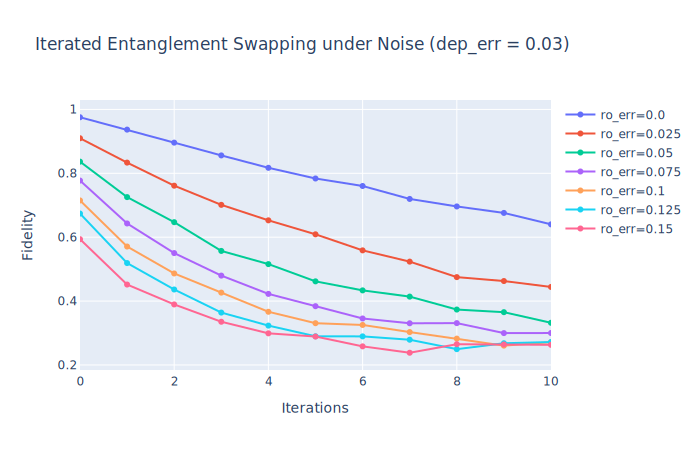

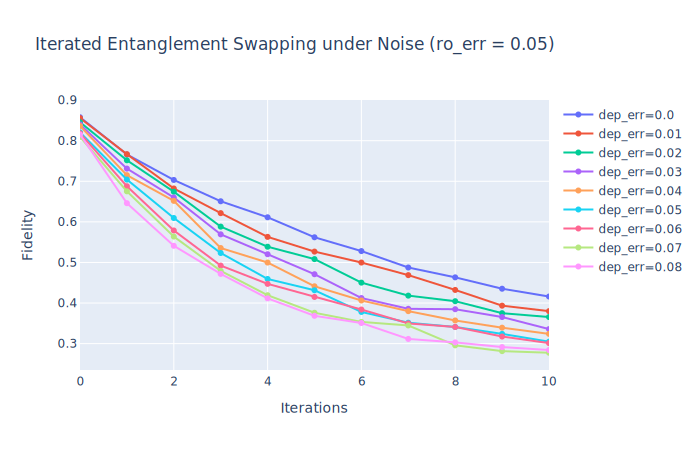

In [7]:
from pytket import OpType
from plotly.graph_objects import Scatter, Figure

def iterated_entanglement_swap(n_iter):
    # Iterate the entanglement swapping protocol n_iter times
    it_es = Circuit()
    ava = it_es.add_q_register("a", 1)
    bella = it_es.add_q_register("b", 2)
    charlie = it_es.add_q_register("c", 1)
    data = it_es.add_c_register("d", 2)

    # Start with an initial Bell state
    it_es.H(ava[0])
    it_es.CX(ava[0], bella[0])

    for i in range(n_iter):
        if i % 2 == 0:
            # Teleport bella[0] to charlie[0] to give a Bell pair between ava[0] and charlier[0]
            tel_to_c = qtel.copy()
            tel_to_c.rename_units({alice[0] : bella[0], alice[1] : bella[1], bob[0] : charlie[0]})
            it_es.append(tel_to_c)
            it_es.add_gate(OpType.Reset, [bella[0]])
            it_es.add_gate(OpType.Reset, [bella[1]])
        else:
            # Teleport charlie[0] to bella[0] to give a Bell pair between ava[0] and bella[0]
            tel_to_b = qtel.copy()
            tel_to_b.rename_units({alice[0] : charlie[0], alice[1] : bella[1], bob[0] : bella[0]})
            it_es.append(tel_to_b)
            it_es.add_gate(OpType.Reset, [bella[1]])
            it_es.add_gate(OpType.Reset, [charlie[0]])
    # Return the circuit and the qubits expected to share a Bell pair
    if n_iter % 2 == 0:
        return it_es, [ava[0], bella[0]]
    else:
        return it_es, [ava[0], charlie[0]]

def iterated_noisy_experiment(dep_err_rate, ro_err_rate, max_iter):
    # Set up the noisy simulator with the given error rates
    test_model = make_noise_model(dep_err_rate, ro_err_rate, range(4))
    backend = AerBackend(noise_model=test_model)
    # Estimate the fidelity after n iterations, from 0 to max_iter (inclusive)
    fid_list = []
    for i in range(max_iter+1):
        it_es, qubits = iterated_entanglement_swap(i)
        probs_list = run_tomography_circuits(it_es, qubits, [data[0], data[1]], backend)
        dm = fit_tomography_outcomes(probs_list, 2)
        fid = fidelity(dm, bell_state)
        fid_list.append(fid)
    return fid_list

fig = Figure()
fig.update_layout(title='Iterated Entanglement Swapping under Noise (dep_err = 0.03)',
                   xaxis_title='Iterations',
                   xaxis=dict(range=[0, 10]),
                   yaxis_title='Fidelity')
iter_range = np.arange(11)
for i in range(7):
    fids = iterated_noisy_experiment(0.03, 0.025*i, 10)
    plot_data = Scatter(x=iter_range, y=fids, name="ro_err="+str(np.round(0.025*i, 3)))
    fig.add_trace(plot_data)
fig.show(renderer="svg")

fig = Figure()
fig.update_layout(title='Iterated Entanglement Swapping under Noise (ro_err = 0.05)',
                   xaxis_title='Iterations',
                   xaxis=dict(range=[0, 10]),
                   yaxis_title='Fidelity')
iter_range = np.arange(11)
for i in range(9):
    fids = iterated_noisy_experiment(0.01*i, 0.05, 10)
    plot_data = Scatter(x=iter_range, y=fids, name="dep_err="+str(np.round(0.01*i, 3)))
    fig.add_trace(plot_data)
fig.show(renderer="svg")

These graphs are not very surprising, but are still important for seeing that the current error rates of typical NISQ devices become crippling for fidelities very quickly after repeated mid-circuit measurements and corrections (even with this overly-simplified model with uniform noise and no crosstalk or higher error modes). This provides good motivation for the adoption of error mitigation techniques, and for the development of new techniques that are robust to errors in mid-circuit measurements.

Exercises:

- Vary the fixed noise levels to compare how impactful the depolarising and measurement errors are.
- Add extra noise characteristics to the noise model to obtain something that more resembles a real device. Possible options include adding error during the reset operations, extending the errors to be non-local, or constructing the noise model from a device's calibration data.
- Change the circuit from iterated entanglement swapping to iterated applications of a correction circuit from a simple error-correcting code. Do you expect this to be more sensitive to depolarising errors from unitary gates or measurement errors?